### Authors
### Group 3 Members

1. Michael Mumina (Scrum Master)
2. Sharon Nyakeya
3. Bryan Njogu
4. Ashley Kibwogo
5. Tanveer Chege
6. Claris Wangari
7. Priscillah Giriama

# Sudan Food Insecurity and Displacement Model

This analysis delivers a decision-ready prototype for humanitarian early warning, providing forward-looking identification of food insecurity deterioration, displacement pressure, and key risk drivers at relevant administrative levels. 

The model integrates multi-sector signals into a coherent risk framework that supports prioritization and situational awareness. 

While advanced components such as probabilistic uncertainty bounds, formal hotspot clustering, and response-rule optimization are not yet operationalized, the current system establishes a robust analytical backbone that can be readily extended into a fully operational decision-support tool.

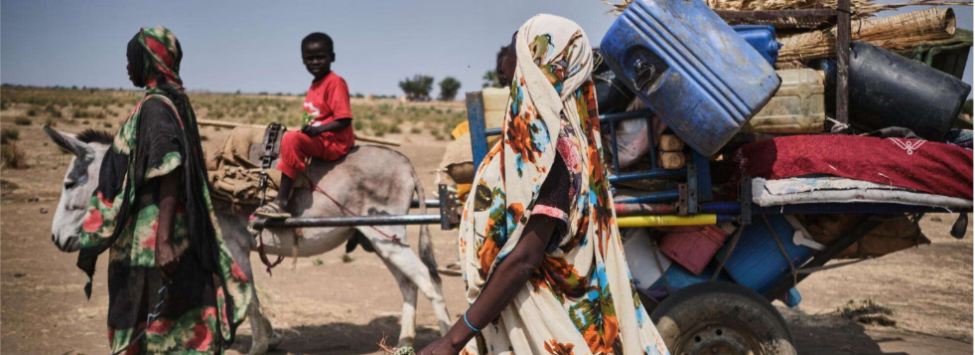

Point of Reference:
IPC Sudan Acute Food Insecurity Snapshot (Oct 2024 – May 2025): https://www.ipcinfo.org/fileadmin/user_upload/ipcinfo/docs/IPC_Sudan_Acute_Food_Insecurity_Oct2024_May2025_Snapshot.pdf

## 2) Business Understanding

### 2.1 Problem Scope:

The prototype is immediately usable for strategic planning and anticipatory action, enabling decision-makers to:
- Identify where conditions are likely to deteriorate in the coming month
- Compare displacement pressure across states and localities
- Understand the primary drivers contributing to elevated risk

Most existing systems are **reactive snapshots**. 
Our project aims to provide key inputs to the above listed key points.


## Target Stakeholders

Our main stake holders are :
1. Humanitarian Aid Organizations such as WHO, UN , UNEP etc
2. Sudan Government 

## 3) Project Objectives
## 1. IPC Food Insecurity Forecasting (State Level) 
Forecast one month ahead:
- **Regression:** next-month IPC3+ percentage  
- **Classification:** probability that IPC3+ worsens next month ( 2 percentage point increase)

Outputs:
- monthly risk ranking by state  
- top drivers for each state-month prediction  
- uncertainty/confidence flags

## 2. Displacement Pressure Monitoring and Hotspot Intelligence

Produce monthly operational outputs:
- **State pressure rankings**:
  - total IDPs by state
- **Hotspot and concentration intelligence**:
  - top localities contributing to state IDP burden
  - concentration measures (e.g., top 3 localities share)

Why this matters:
- High displacement pressure increases vulnerability via service strain, market stress, and household fragility.
- Hotspot intelligence supports locality-level targeting (Admin2) for assessments and interventions.


## 1. Data Understanding & Preparation


In [1]:
#import libriries
import pandas as pd                  # For working with datasets (tables, CSV, Excel, dataframes)
import numpy as np                   # For numerical operations, arrays, math functions
import matplotlib.pyplot as plt      # For plotting graphs and data visualizations
import seaborn as sns                # For advanced statistical visualizations built on top of matplotlib
from sklearn.model_selection import train_test_split            # Split data into training and testing sets
from sklearn.linear_model import LogisticRegression             # Logistic Regression classifier
from sklearn.ensemble import RandomForestClassifier             # Ensemble model using multiple decision trees
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report                  # Confusion matrix & summary report
import glob
import pandas as pd
import re
import pandas as pd
import requests
from io import BytesIO
import zipfile, os
import geopandas as gpd
from pathlib import Path
from PIL import Image



### Step 1 — Load the data

In [2]:
df = pd.read_csv("regional_food_security_master.csv", low_memory=False)
df.shape, df.columns


((26145, 132),
 Index(['Date of analysis', 'Country', 'Total country population', 'state',
        'Area', 'Validity period', 'From', 'To', 'Phase', 'Number',
        ...
        'T_35_39_2025', 'T_40_44_2025', 'T_45_49_2025', 'T_50_54_2025',
        'T_55_59_2025', 'T_60_64_2025', 'T_65_69_2025', 'T_70_74_2025',
        'T_75_79_2025', 'T_80Plus_2025'],
       dtype='object', length=132))

### Step 2 — Remove metadata rows and parse dates

In [3]:
df = df[~df["From"].astype(str).str.startswith("#")].copy()

df["From"] = pd.to_datetime(df["From"], errors="coerce")
df = df.dropna(subset=["From"]).copy()

df["month"] = df["From"].dt.to_period("M").dt.to_timestamp()
df[["From","month"]].head()


,From,month
0,2025-09-01,2025-09-01
1,2025-09-01,2025-09-01
2,2025-09-01,2025-09-01
3,2025-09-01,2025-09-01
4,2025-09-01,2025-09-01


### Step 3 — Standardize keys (Country, Phase, admin)

In [4]:
df["Country"] = df["Country"].astype(str).str.strip()
df["Phase"]   = df["Phase"].astype(str).str.strip()

df["admin"] = df["Area"].where(df["Area"].notna(), df["state"]).astype(str).str.strip()
df[["Country","admin","Phase"]].head()


,Country,admin,Phase
0,SDN,Beida,all
1,SDN,Beida,3+
2,SDN,Beida,1
3,SDN,Beida,2
4,SDN,Beida,3


### Step 4 — Clean numeric percentage

In [5]:
df["Percentage"] = pd.to_numeric(df["Percentage"], errors="coerce")
clean_long = df.dropna(subset=["Country","admin","month","Phase","Percentage"]).copy()

clean_long.shape


(26145, 134)


Our model has been built on various data sets namely:

1. IPC datasets — Food insecurity truth signal
2. Displacement datasets — Needs and pressure signal
3. WFP price datasets — Economic stress signal
4. Rainfall dataset — Climate stress signal
5. Conflict datasets — Shock and disruption signal
6. Population and vulnerability — Exposure and normalization

### 1.1.1 Download an Excel dataset, lists all sheets, and previews the first few rows of each for quick inspection.

In [6]:
import pandas as pd
import requests
from io import BytesIO

url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

# Fetching the data
r = requests.get(url, timeout=60)
r.raise_for_status()

# Loading into pandas
xls = pd.ExcelFile(BytesIO(r.content))
print("Sheets found:", xls.sheet_names)

# Previewing sheets
for s in xls.sheet_names:
    try:
        df = xls.parse(s, nrows=3)
        print(f"\n--- Sheet: {s} ---")
        print(df)
    except Exception as e:
        print(f"\n--- Sheet: {s} --- (Error reading: {e})")

Sheets found: ['MASTER LIST (ADMIN1)', 'MASTER LIST (ADMIN 2)', 'Read Me', 'PoO per Localities', 'SAAD by Locality', 'Admin_label', 'Option']

--- Sheet: MASTER LIST (ADMIN1) ---
  DTM SUDAN: IDP Master List 25-04-2024  Unnamed: 1 Unnamed: 2 Unnamed: 3  \
0                                   NaN         NaN        NaN        NaN   
1                  LOCATION INFORMATION         NaN      TOTAL        NaN   
2                  STATE OF DISPLACEMET  STATE CODE       IDPs        HHs   

                      Unnamed: 4      Unnamed: 5   Unnamed: 6 Unnamed: 7  \
0                            NaN             NaN          NaN        NaN   
1  STATE of ORIGIN BY INDIVIUALS             NaN          NaN        NaN   
2                     Aj Jazirah  Central Darfur  East Darfur   Khartoum   

     Unnamed: 8      Unnamed: 9 Unnamed: 10   Unnamed: 11     Unnamed: 12  \
0           NaN             NaN         NaN           NaN             NaN   
1           NaN             NaN         NaN          

### 1.1.2  This code Downloads an Excel dataset, extracts Admin-1 level displacement data, cleans and standardizes key columns, and saves the processed results as a CSV file.

In [7]:
url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

# download the xlsx
r = requests.get(url, timeout=60)
r.raise_for_status()

# read the Admin1 sheet (header row already detected as header=2 from your earlier run)
df = pd.read_excel(BytesIO(r.content), sheet_name="MASTER LIST (ADMIN1)", header=2)

# keep only the four columns we need
state = df[["LOCATION INFORMATION", "Unnamed: 1", "TOTAL", "Unnamed: 3"]].copy()

# rename to clean names
state.columns = ["state", "state_code", "idps", "households"]

# clean: remove empty rows + force idps numeric
state["state"] = state["state"].astype(str).str.strip()
state["idps"] = pd.to_numeric(state["idps"], errors="coerce")

state = state.dropna(subset=["state", "idps"])
state = state[state["state"].str.lower().ne("nan")]

# save one CSV
state.to_csv("sudan_admin1_idps_2024-04-25.csv", index=False)

print("Saved: sudan_admin1_idps_2024-04-25.csv")
print(state.head())


Saved: sudan_admin1_idps_2024-04-25.csv
            state state_code      idps households
2      Aj Jazirah       SD15  371177.0      73323
3       Blue Nile       SD08  147736.0      29836
4  Central Darfur       SD06  430224.0      86044
5     East Darfur       SD05  660140.0     131918
6         Gedaref       SD12  492293.0      97817


### 1.1.3  Print and check the current working directory of the Python environment.

In [8]:
import os
print(os.getcwd())

C:\Users\user\Documents\Humanitarian


### 1.1.4  This code Downloads displacement data, extracts and cleans Admin-1 level statistics, saves the results as a CSV file, and prints the file’s saved location.

In [10]:
url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

r = requests.get(url, timeout=60)
r.raise_for_status()

df = pd.read_excel(BytesIO(r.content), sheet_name="MASTER LIST (ADMIN1)", header=2)

state = df[["LOCATION INFORMATION", "Unnamed: 1", "TOTAL", "Unnamed: 3"]].copy()
state.columns = ["state", "state_code", "idps", "households"]

state["state"] = state["state"].astype(str).str.strip()
state["idps"] = pd.to_numeric(state["idps"], errors="coerce")

state = state.dropna(subset=["state", "idps"])
state = state[state["state"].str.lower().ne("nan")]

out_file = "sudan_admin1_idps_2024-04-25.csv"  # saved in C:\Users\user\Documents\Humanitarian
state.to_csv(out_file, index=False)

print("Saved to:", os.path.abspath(out_file))

Saved to: C:\Users\user\Documents\Humanitarian\sudan_admin1_idps_2024-04-25.csv


### 1.1.5  The below Downloads Sudan Admin-1 boundary data in GeoJSON format and saves it locally for mapping or spatial analysis.

In [11]:
# This is the direct GeoJSON (WFS) endpoint for Sudan Admin1 boundaries
geojson_url = (
    "https://geoportal.icpac.net/geoserver/ows?"
    "service=WFS&version=1.0.0&request=GetFeature&"
    "typename=geonode:sudan_admin_level1&"
    "outputFormat=json&srsName=EPSG:4326"
)

out_file = "sudan_admin1.geojson"  # will save in your current notebook folder

r = requests.get(geojson_url, timeout=120)
r.raise_for_status()

with open(out_file, "wb") as f:
    f.write(r.content)

print("Saved boundary file to:", os.path.abspath(out_file))
print("File size (bytes):", os.path.getsize(out_file))


Saved boundary file to: C:\Users\user\Documents\Humanitarian\sudan_admin1.geojson
File size (bytes): 339637


### 1.1.6  The below code Loads displacement data, standardizes and cleans fields, removes invalid rows, aggregates duplicates by state, performs quality checks, and saves a final cleaned CSV ready for analysis or deployment.

In [12]:
# 1) Load your displacement CSV
df = pd.read_csv("sudan_admin1_idps_2024-04-25.csv")

# 2) Standardize column names (lowercase, underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Expected columns after your extraction:
# state, state_code, idps, households
print("Columns:", list(df.columns))

# 3) Clean text + numeric types
df["state"] = df["state"].astype(str).str.strip()
df["state_code"] = df["state_code"].astype(str).str.strip()

df["idps"] = pd.to_numeric(df["idps"], errors="coerce")
df["households"] = pd.to_numeric(df["households"], errors="coerce")

# 4) Drop empty rows
df = df.dropna(subset=["state", "idps"])

# 5) Remove obvious totals / junk rows (professional hygiene)
bad = {"total", "grand total", "overall", "nan", ""}
df = df[~df["state"].str.lower().isin(bad)]

# 6) Deduplicate safely (if duplicates exist, sum them)
df_clean = (
    df.groupby(["state_code", "state"], as_index=False)[["idps", "households"]]
      .sum()
)

# 7) Professional QA checks
print("\n--- QA SUMMARY ---")
print("Rows (states):", len(df_clean))
print("Unique state_code:", df_clean["state_code"].nunique())
print("Missing state_code:", df_clean["state_code"].isna().sum())
print("Any duplicate state_code:", df_clean["state_code"].duplicated().any())

print("\nTop 10 states by IDPs:")
display(df_clean.sort_values("idps", ascending=False).head(10))

print("\nAll states (sorted A–Z):")
display(df_clean.sort_values("state")[["state_code", "state", "idps", "households"]])

# 8) Save the cleaned table (deployment-friendly, stable schema)
df_clean.to_csv("sudan_admin1_idps_2024-04-25_CLEAN.csv", index=False)
print("\nSaved: sudan_admin1_idps_2024-04-25_CLEAN.csv")

Columns: ['state', 'state_code', 'idps', 'households']

--- QA SUMMARY ---
Rows (states): 18
Unique state_code: 18
Missing state_code: 0
Any duplicate state_code: False

Top 10 states by IDPs:


,state_code,state,idps,households
2,SD03,South Darfur,744243.0,148848
15,SD16,River Nile,698334.0,137799
4,SD05,East Darfur,660140.0,131918
1,SD02,North Darfur,573055.0,114503
8,SD09,White Nile,532643.0,105920
13,SD14,Sennar,523986.0,104002
11,SD12,Gedaref,492293.0,97817
5,SD06,Central Darfur,430224.0,86044
16,SD17,Northern,399867.0,80305
14,SD15,Aj Jazirah,371177.0,73323



All states (sorted A–Z):


,state_code,state,idps,households
14,SD15,Aj Jazirah,371177.0,73323
7,SD08,Blue Nile,147736.0,29836
5,SD06,Central Darfur,430224.0,86044
4,SD05,East Darfur,660140.0,131918
11,SD12,Gedaref,492293.0,97817
10,SD11,Kassala,200083.0,40282
0,SD01,Khartoum,69057.0,13717
1,SD02,North Darfur,573055.0,114503
12,SD13,North Kordofan,174007.0,34261
16,SD17,Northern,399867.0,80305



Saved: sudan_admin1_idps_2024-04-25_CLEAN.csv


### 1.1.7  Below code Builds a 2023 Admin-1 displacement panel by looping through multiple Excel files, extracting state-level IDPs/households, deriving report dates from sheet names, ranking states (top 5 hotspots), and exporting a combined monthly dataset to CSV.
import glob

In [13]:
import glob
import pandas as pd
import re

HOTSPOT_TOPK = 5
rows_all = []

files = sorted(glob.glob("data/2023_excels/*.xlsx"))
print("Files found:", len(files))

def pick_dataset_sheet(sheet_names):
    # Prefer "Dataset (...)" sheets
    for s in sheet_names:
        if str(s).lower().startswith("dataset"):
            return s
    return sheet_names[0]

def extract_date_from_sheetname(s):
    # "Dataset (27 April 2023)" -> 2023-04-27
    m = re.search(r"\((.+)\)", str(s))
    if not m:
        return None
    txt = m.group(1)
    try:
        return pd.to_datetime(txt, dayfirst=True, errors="raise")
    except Exception:
        return pd.to_datetime(txt, errors="coerce")

for path in files:
    xls = pd.ExcelFile(path)
    sheet = pick_dataset_sheet(xls.sheet_names)

    df = pd.read_excel(path, sheet_name=sheet)

    # map columns (exact names from your sample)
    col_state = "STATE OF AFFECTED POPULATION"
    col_code  = "STATE PCODE OF AFFECTED POPULATION"
    col_idps  = "# IDP INDIVIDUALS  "
    col_hh    = "# IDP HOUSEHOLDS  "

    # safety: only proceed if required columns exist
    if not all(c in df.columns for c in [col_state, col_code, col_idps, col_hh]):
        continue

    out = df[[col_state, col_code, col_idps, col_hh]].copy()
    out.columns = ["state_name", "state_code", "idps", "households"]

    out["state_name"] = out["state_name"].astype(str).str.strip()
    out["state_code"] = out["state_code"].astype(str).str.strip()

    out["idps"] = pd.to_numeric(out["idps"], errors="coerce")
    out["households"] = pd.to_numeric(out["households"], errors="coerce")

    # admin1 panel: sum within affected state
    out = (out.groupby(["state_code", "state_name"], as_index=False)
              .agg({"idps":"sum", "households":"sum"}))

    # report_date from sheet name (best available in these files)
    report_date = extract_date_from_sheetname(sheet)
    if pd.isna(report_date):
        # fallback: skip if we can't date it
        continue

    out["report_date"] = report_date.normalize()
    out["month_start"] = report_date.to_period("M").to_timestamp()

    # rank + hotspot (per report)
    out = out.sort_values("idps", ascending=False).reset_index(drop=True)
    out["rank"] = out.index + 1
    out["hotspot"] = out["rank"] <= HOTSPOT_TOPK

    # keep only the 18 states (if extras exist, take top 18 by idps)
    out = out.head(18)

    print("Processing:", out["report_date"].iloc[0].date(), "| States:", len(out))
    rows_all.append(out)

panel_2023 = pd.concat(rows_all, ignore_index=True)
panel_2023.to_csv("sudan_admin1_idps_panel_2023.csv", index=False)

print("\nSaved: sudan_admin1_idps_panel_2023.csv")
print("Rows:", len(panel_2023), "| Months:", panel_2023["month_start"].nunique(), "| States:", panel_2023["state_code"].nunique())

# show latest report like your example
latest = panel_2023["report_date"].max()
print("\nLatest report_date:", latest.date())
print(panel_2023[panel_2023["report_date"] == latest].sort_values("rank")[[
    "state_code","state_name","idps","households","report_date","month_start","rank","hotspot"
]].to_string(index=False))


Files found: 34
Processing: 2023-04-27 | States: 15

Saved: sudan_admin1_idps_panel_2023.csv
Rows: 15 | Months: 1 | States: 15

Latest report_date: 2023-04-27
 state_code     state_name     idps  households report_date month_start  rank  hotspot
       SD04    West Darfur 194593.0     38919.0  2023-04-27  2023-04-01     1     True
       SD03   South Darfur  45000.0      9000.0  2023-04-27  2023-04-01     2     True
       SD17       Northern  29200.0      5840.0  2023-04-27  2023-04-01     3     True
       SD01       Khartoum  13545.0      2709.0  2023-04-27  2023-04-01     4     True
       SD13 North Kordofan  13270.0      2654.0  2023-04-27  2023-04-01     5     True
       SD02   North Darfur  11675.0      2335.0  2023-04-27  2023-04-01     6    False
       SD15     Aj Jazirah   8795.0      1759.0  2023-04-27  2023-04-01     7    False
       SD09     White Nile   6165.0      1233.0  2023-04-27  2023-04-01     8    False
       SD14         Sennar   5560.0      1112.0  2023-04-2

### 1.1.8  Below code Creates a fixed 18-state Admin-1 reference list, merges it into each report date to ensure all states are present (filling missing values with zero), recalculates ranks and top-5 hotspots per report, and saves a consistent 18-state monthly panel to CSV.

In [14]:
# Fixed Sudan Admin1 spine (SD01–SD18)
spine = pd.DataFrame([
    ("SD01","Khartoum"),
    ("SD02","North Darfur"),
    ("SD03","South Darfur"),
    ("SD04","West Darfur"),
    ("SD05","East Darfur"),
    ("SD06","Central Darfur"),
    ("SD07","South Kordofan"),
    ("SD08","Blue Nile"),
    ("SD09","White Nile"),
    ("SD10","Red Sea"),
    ("SD11","Kassala"),
    ("SD12","Gedaref"),
    ("SD13","North Kordofan"),
    ("SD14","Sennar"),
    ("SD15","Aj Jazirah"),
    ("SD16","River Nile"),
    ("SD17","Northern"),
    ("SD18","West Kordofan"),
], columns=["state_code","state_name"])

# panel_2023 is your extracted (before spine-fill). If you only have panel_2023_fixed loaded,
# read it back and treat it as the extracted input:
panel = panel_2023.copy() if "panel_2023" in globals() else pd.read_csv("sudan_admin1_idps_panel_2023.csv", parse_dates=["report_date","month_start"])

fixed = []
for d, g in panel.groupby("report_date"):
    m = spine.merge(g[["state_code","idps","households"]], on="state_code", how="left")
    m["report_date"] = pd.to_datetime(d)
    m["month_start"] = pd.to_datetime(d).to_period("M").to_timestamp()
    m["idps"] = m["idps"].fillna(0)
    m["households"] = m["households"].fillna(0)

    m = m.sort_values("idps", ascending=False).reset_index(drop=True)
    m["rank"] = m.index + 1
    m["hotspot"] = m["rank"] <= HOTSPOT_TOPK
    fixed.append(m)

panel_2023_fixed18 = pd.concat(fixed, ignore_index=True)
panel_2023_fixed18.to_csv("sudan_admin1_idps_panel_2023.csv", index=False)

print("Saved: sudan_admin1_idps_panel_2023.csv")
print("Rows:", len(panel_2023_fixed18), "| Dates:", panel_2023_fixed18["report_date"].nunique(), "| States:", panel_2023_fixed18["state_code"].nunique())

# show latest block
latest = panel_2023_fixed18["report_date"].max()
print("\nProcessing:", latest.date())
print(panel_2023_fixed18[panel_2023_fixed18["report_date"] == latest].sort_values("rank")[[
    "state_code","state_name","idps","households","report_date","month_start","rank","hotspot"
]].to_string(index=False))


Saved: sudan_admin1_idps_panel_2023.csv
Rows: 18 | Dates: 1 | States: 18

Processing: 2023-04-27
state_code     state_name     idps  households report_date month_start  rank  hotspot
      SD04    West Darfur 194593.0     38919.0  2023-04-27  2023-04-01     1     True
      SD03   South Darfur  45000.0      9000.0  2023-04-27  2023-04-01     2     True
      SD17       Northern  29200.0      5840.0  2023-04-27  2023-04-01     3     True
      SD01       Khartoum  13545.0      2709.0  2023-04-27  2023-04-01     4     True
      SD13 North Kordofan  13270.0      2654.0  2023-04-27  2023-04-01     5     True
      SD02   North Darfur  11675.0      2335.0  2023-04-27  2023-04-01     6    False
      SD15     Aj Jazirah   8795.0      1759.0  2023-04-27  2023-04-01     7    False
      SD09     White Nile   6165.0      1233.0  2023-04-27  2023-04-01     8    False
      SD14         Sennar   5560.0      1112.0  2023-04-27  2023-04-01     9    False
      SD16     River Nile   2910.0       58

### 1.1.9  Below code Loads a combined 2023–2024 displacement panel, selects geography-ready fields, exports them to a CSV for mapping snapshots, and prints basic dataset statistics.

In [15]:
panel = pd.read_csv("sudan_admin1_idps_panel_2023_2024.csv", parse_dates=["report_date","snapshot_month"])

geo = panel[["state_code","state_name","report_date","idps","households","rank","hotspot","year"]].copy()
geo.to_csv("geo_admin1_snapshots_2023_2024.csv", index=False)

print("Saved: geo_admin1_snapshots_2023_2024.csv")
print("Rows:", len(geo), "| Dates:", geo["report_date"].nunique(), "| States:", geo["state_code"].nunique())


Saved: geo_admin1_snapshots_2023_2024.csv
Rows: 54 | Dates: 3 | States: 18


### 1.1.10  Below code Splits the geographic displacement dataset into separate CSV files by report date and saves each snapshot to a date-named folder for easy mapping or time-series use.

In [16]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024.csv", parse_dates=["report_date"])
os.makedirs("geo_by_date", exist_ok=True)

for d in sorted(df["report_date"].unique()):
    sub = df[df["report_date"] == d].copy()
    out = f"geo_by_date/geo_admin1_{pd.to_datetime(d).date()}.csv"
    sub.to_csv(out, index=False)
    print("Saved:", out, "| rows:", len(sub))


Saved: geo_by_date/geo_admin1_2023-04-27.csv | rows: 18
Saved: geo_by_date/geo_admin1_2023-05-05.csv | rows: 18
Saved: geo_by_date/geo_admin1_2024-04-25.csv | rows: 18


### 1.1.11  Below code Identifies the top 5 displacement hotspot states per report date based on IDPs, saves the results to a CSV file, and prints a concise hotspot summary table.

In [17]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024.csv", parse_dates=["report_date"])

top5 = (df.sort_values(["report_date","idps"], ascending=[True, False])
          .groupby("report_date")
          .head(5)
          .copy())

top5.to_csv("report_hotspots_top5_by_date.csv", index=False)
print("Saved: report_hotspots_top5_by_date.csv")
print(top5[["report_date","state_code","state_name","idps","rank","hotspot"]].to_string(index=False))


Saved: report_hotspots_top5_by_date.csv
report_date state_code     state_name     idps  rank  hotspot
 2023-04-27       SD04    West Darfur 194593.0   1.0     True
 2023-04-27       SD03   South Darfur  45000.0   2.0     True
 2023-04-27       SD17       Northern  29200.0   3.0     True
 2023-04-27       SD01       Khartoum  13545.0   4.0     True
 2023-04-27       SD13 North Kordofan  13270.0   5.0     True
 2023-05-05       SD09     White Nile 188635.0   1.0     True
 2023-05-05       SD04    West Darfur 156565.0   2.0     True
 2023-05-05       SD17       Northern 106600.0   3.0     True
 2023-05-05       SD16     River Nile  96095.0   4.0     True
 2023-05-05       SD15     Aj Jazirah  49280.0   5.0     True
 2024-04-25       SD03   South Darfur 744243.0   1.0     True
 2024-04-25       SD16     River Nile 698334.0   2.0     True
 2024-04-25       SD05    East Darfur 660140.0   3.0     True
 2024-04-25       SD02   North Darfur 573055.0   4.0     True
 2024-04-25       SD09     Whi

### 1.1.13  Below code Adds a global IDP-based intensity metric by normalizing displacement counts against the overall maximum across all dates, then updates the dataset for consistent cross-time comparison.

In [18]:
import pandas as pd
df = pd.read_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", parse_dates=["report_date"])

global_max = df["idps"].max()
df["intensity_idps_global"] = df["idps"] / global_max

df.to_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", index=False)
print("Updated with intensity_idps_global. Global max:", global_max)


Updated with intensity_idps_global. Global max: 744243.0


### 1.1.14 Below code Splits the intensity-enhanced displacement dataset into per-date GIS-ready CSV files, keeping only essential fields and a globally comparable intensity metric for consistent map symbolization.

In [19]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", parse_dates=["report_date"])

# pick the intensity field you want to symbolize
# global comparable across dates:
value_col = "intensity_idps_global"

out_dir = "geo_by_date_intensity"
os.makedirs(out_dir, exist_ok=True)

for d in sorted(df["report_date"].unique()):
    sub = df[df["report_date"] == d].copy()

    # keep only what GIS needs (simple)
    sub = sub[[
        "state_code", "state_name", "report_date",
        "idps", "households",
        "rank", "hotspot",
        "hotspot_intensity_rank",
        "intensity_idps_global",
        "intensity_idps_share"
    ]].copy()

    out = os.path.join(out_dir, f"geo_admin1_{pd.to_datetime(d).date()}_intensity.csv")
    sub.to_csv(out, index=False)
    print("Saved:", out, "| rows:", len(sub), "| symbolize:", value_col)


Saved: geo_by_date_intensity\geo_admin1_2023-04-27_intensity.csv | rows: 18 | symbolize: intensity_idps_global
Saved: geo_by_date_intensity\geo_admin1_2023-05-05_intensity.csv | rows: 18 | symbolize: intensity_idps_global
Saved: geo_by_date_intensity\geo_admin1_2024-04-25_intensity.csv | rows: 18 | symbolize: intensity_idps_global


### 1.1.15  Below code Unzips an uploaded GeoJSON boundary file, loads it with GeoPandas, inspects its structure, and identifies likely administrative code fields for joining with displacement data.

In [20]:
import zipfile, os
import geopandas as gpd

zip_path = "sdn_admin_boundaries.geojson.zip"  # if this fails, replace with the exact filename you uploaded

out_dir = "sdn_admin_boundaries_unzipped"
os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(out_dir)

# find the geojson file
geojson_files = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if f.lower().endswith(".geojson")]
print("GeoJSON files:", geojson_files)

gdf = gpd.read_file(geojson_files[0])
print("Rows:", len(gdf))
print("Columns:", list(gdf.columns))

# show likely join fields
cand = [c for c in gdf.columns if "pcode" in c.lower() or "code" in c.lower()]
print("Candidate code fields:", cand)

gdf.head(3)


GeoJSON files: ['sdn_admin_boundaries_unzipped\\sdn_admin0.geojson', 'sdn_admin_boundaries_unzipped\\sdn_admin1.geojson', 'sdn_admin_boundaries_unzipped\\sdn_admin2.geojson', 'sdn_admin_boundaries_unzipped\\sdn_adminlines.geojson', 'sdn_admin_boundaries_unzipped\\sdn_adminpoints.geojson']
Rows: 1
Columns: ['iso2', 'iso3', 'adm0_name', 'adm0_name1', 'adm0_name2', 'adm0_name3', 'adm0_pcode', 'valid_on', 'valid_to', 'version', 'area_sqkm', 'lang', 'lang1', 'lang2', 'lang3', 'adm0_ref_name', 'center_lat', 'center_lon', 'geometry']
Candidate code fields: ['adm0_pcode']


,iso2,iso3,adm0_name,adm0_name1,adm0_name2,adm0_name3,adm0_pcode,valid_on,valid_to,version,area_sqkm,lang,lang1,lang2,lang3,adm0_ref_name,center_lat,center_lon,geometry
0,SD,SDN,Sudan,السودان,None,None,SD,2020-08-31,None,v03,1.871528e+06,en,ar,None,None,Sudan,15.915687,30.39758,"POLYGON ((35.62218 23.14256, 35.62126 23.14277..."


## Explaratory Data Analysis and Visulizations 

### Numeric features in the dataset
This heatmap visualizes the pairwise correlations among all numeric features in the dataset, helping identify strong relationships and potential multicollinearity prior to modeling.

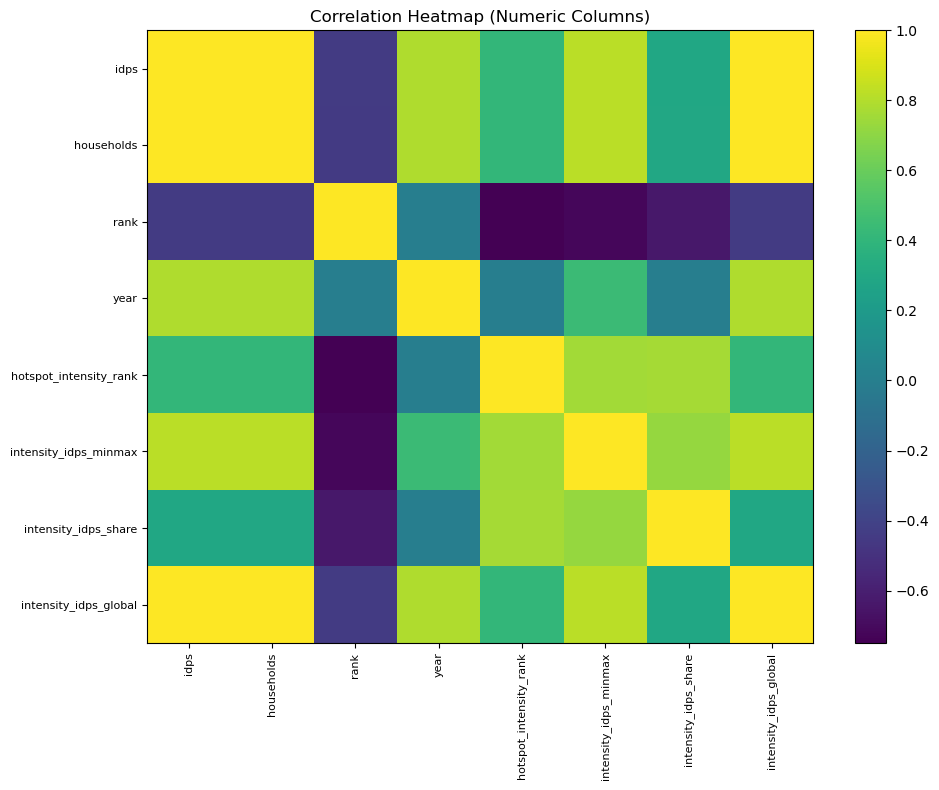

Saved: artifacts\eda\corr_heatmap_numeric.png


In [21]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- archive saver (keeps your structure: artifacts/eda/) ---
ARTIFACTS_DIR = Path("artifacts") / "eda"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

def save_show(fig, name: str, folder: Path = ARTIFACTS_DIR, dpi: int = 200):
    out_path = folder / f"{name}.png"
    fig.tight_layout()
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")

# --- correlation heatmap (numeric columns) ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) < 2:
    print("Not enough numeric columns to compute a correlation matrix.")
else:
    corr = df[num_cols].corr(numeric_only=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_title("Correlation Heatmap (Numeric Columns)")

    ax.set_xticks(range(len(num_cols)))
    ax.set_yticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols, rotation=90, fontsize=8)
    ax.set_yticklabels(num_cols, fontsize=8)

    fig.colorbar(im, ax=ax)
    save_show(fig, "corr_heatmap_numeric")




### Total IDPs Over Time
This line chart shows the trend of total internally displaced persons (IDPs) over time, highlighting changes in displacement levels across reporting dates.

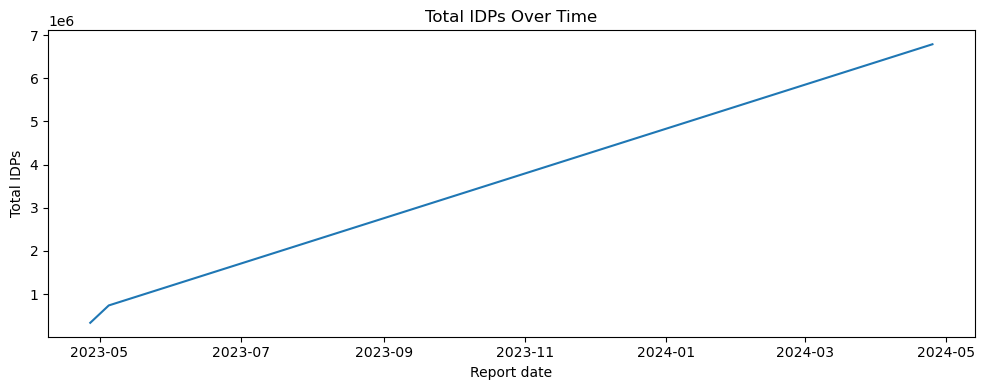

Saved: artifacts\eda\trend_total_idps_over_time.png


In [23]:
trend = (df.dropna(subset=["report_date"])
           .groupby("report_date")["idps"].sum()
           .sort_index())

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(trend.index, trend.values)
ax.set_title("Total IDPs Over Time")
ax.set_xlabel("Report date")
ax.set_ylabel("Total IDPs")
save_show(fig, "trend_total_idps_over_time")


### IDPs Over Time — Top 6 States by Total IDPs
This multi-line chart compares IDP trends over time for the top six states with the highest total number of internally displaced persons, highlighting differences in displacement patterns across states.

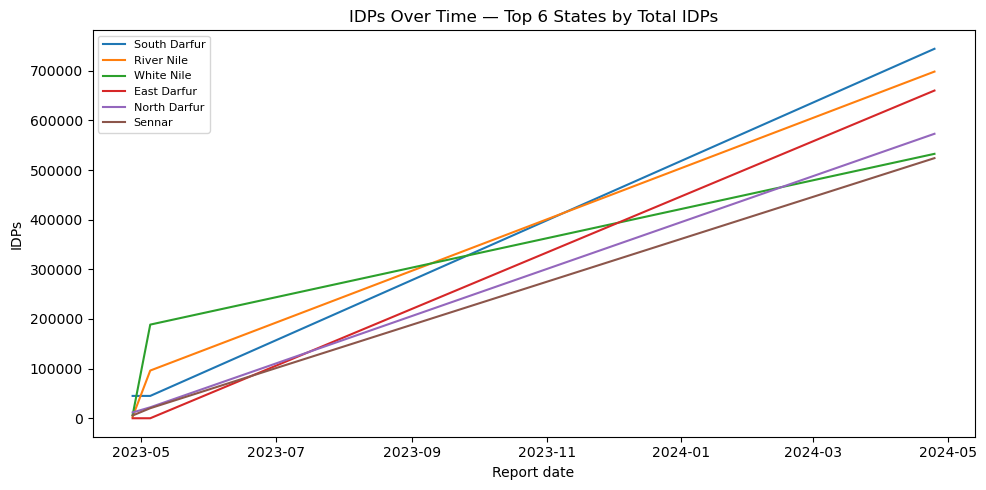

Saved: artifacts\eda\trend_idps_top_states.png


In [24]:
TOP_N = 6
top_states = (df.groupby("state_name")["idps"].sum()
                .sort_values(ascending=False)
                .head(TOP_N)
                .index.tolist())

fig, ax = plt.subplots(figsize=(10, 5))
for s in top_states:
    sub = df[df["state_name"] == s].dropna(subset=["report_date"])
    ts = sub.groupby("report_date")["idps"].sum().sort_index()
    ax.plot(ts.index, ts.values, label=str(s))

ax.set_title(f"IDPs Over Time — Top {TOP_N} States by Total IDPs")
ax.set_xlabel("Report date")
ax.set_ylabel("IDPs")
ax.legend(fontsize=8)
save_show(fig, "trend_idps_top_states")


### Rank Over Time for States
This line chart tracks how a selected state’s rank changes over time, illustrating shifts in its relative position across reporting periods.

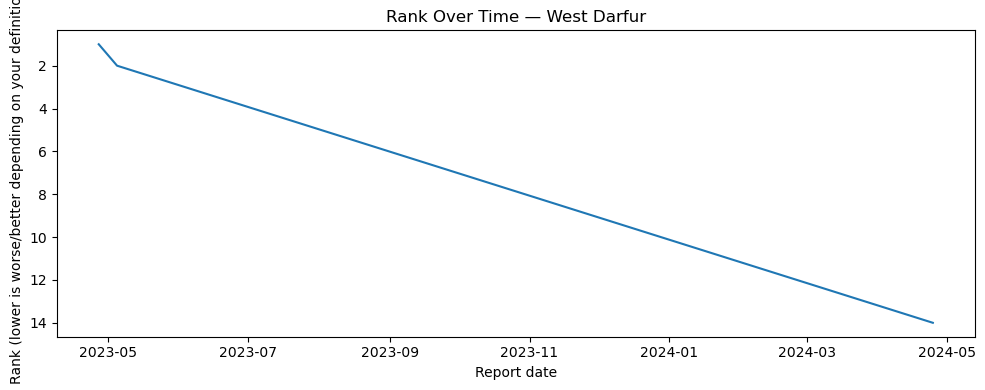

Saved: C:\Users\user\Documents\Humanitarian\artifacts\eda_food\rank_over_time_West_Darfur.png


In [29]:
STATE = df["state_name"].iloc[0]  # change to e.g. "Khartoum"
sub = df[df["state_name"] == STATE].dropna(subset=["report_date"]).sort_values("report_date")

if "rank" in sub.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sub["report_date"], sub["rank"])
    ax.set_title(f"Rank Over Time — {STATE}")
    ax.set_xlabel("Report date")
    ax.set_ylabel("Rank (lower is worse/better depending on your definition)")
    ax.invert_yaxis()  # ranks usually read better inverted (1 at top)
    save_show(fig, f"rank_over_time_{STATE}".replace(" ", "_"))


### Top 15 States by Total IDPs
This bar chart displays the top 15 states ranked by total internally displaced persons (IDPs), highlighting regions with the highest cumulative displacement.

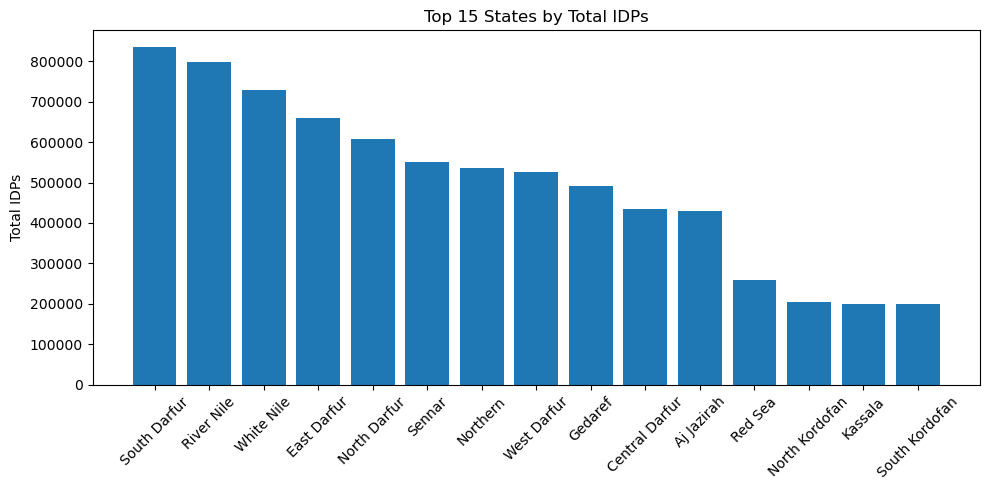

Saved: artifacts\eda\bar_top15_states_total_idps.png


In [25]:
top = (df.groupby("state_name")["idps"].sum()
         .sort_values(ascending=False)
         .head(15))

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top.index.astype(str), top.values)
ax.set_title("Top 15 States by Total IDPs")
ax.set_ylabel("Total IDPs")
ax.tick_params(axis="x", rotation=45)
save_show(fig, "bar_top15_states_total_idps")


### Top 15 States by Total Households
This bar chart shows the top 15 states ranked by total affected households, highlighting regions with the largest cumulative household impact.

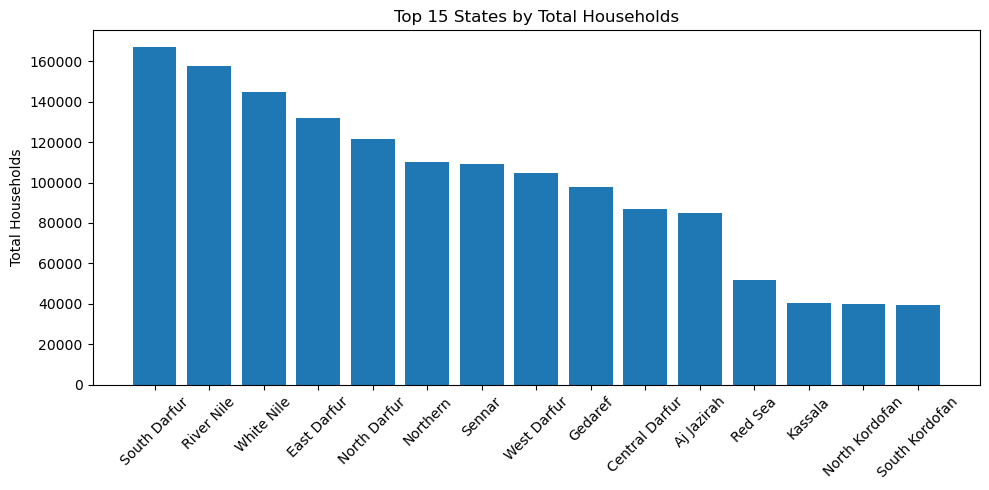

Saved: C:\Users\user\Documents\Humanitarian\artifacts\eda_food\bar_top15_states_total_households.png


In [27]:
top = (df.groupby("state_name")["households"].sum()
         .sort_values(ascending=False)
         .head(15))

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top.index.astype(str), top.values)
ax.set_title("Top 15 States by Total Households")
ax.set_ylabel("Total Households")
ax.tick_params(axis="x", rotation=45)
save_show(fig, "bar_top15_states_total_households")


### Food Security Exploratory Data Analysis (EDA)
This analysis explores regional food security data by visualizing distributions of numeric and categorical food indicators and tracking trends over time.

Loaded food_df: (26145, 132)
Detected food-ish columns: 2


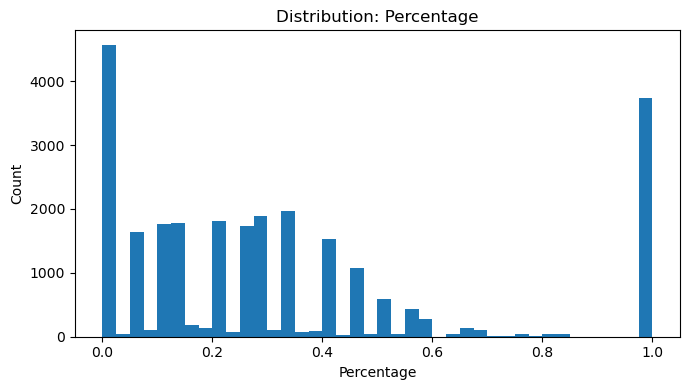

Saved: C:\Users\user\Documents\Humanitarian\artifacts\eda_food\dist_Percentage.png


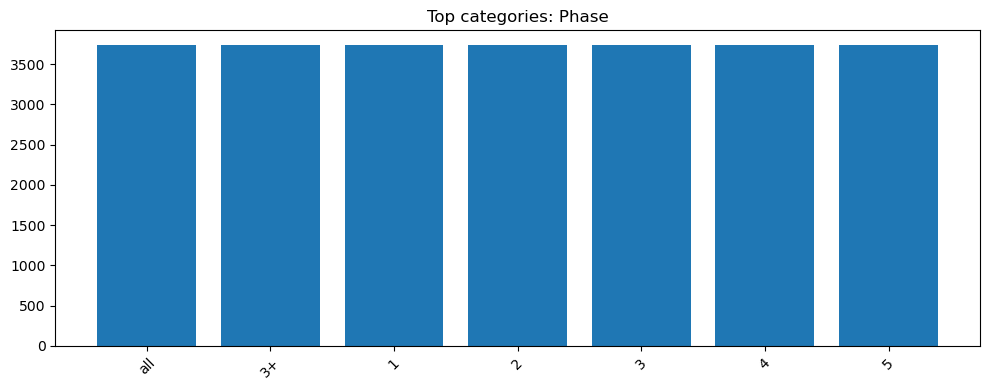

Saved: C:\Users\user\Documents\Humanitarian\artifacts\eda_food\topcats_Phase.png


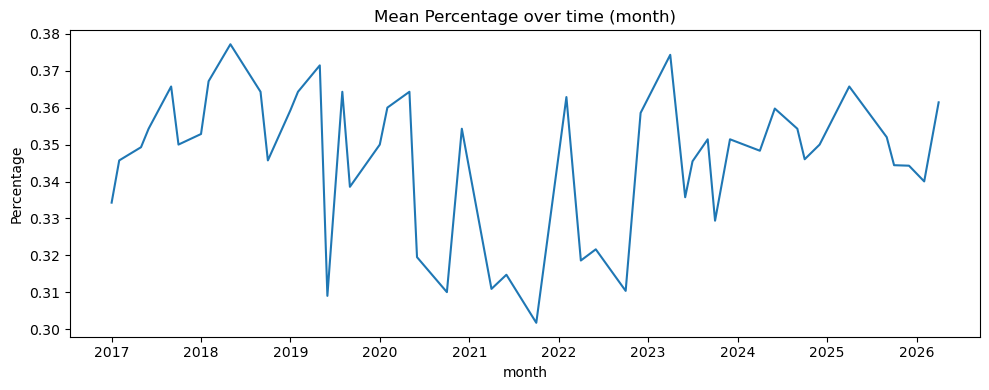

Saved: C:\Users\user\Documents\Humanitarian\artifacts\eda_food\trend_Percentage_by_month.png


In [28]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# 1) Load food data (defines food_df)
# ------------------------
FOOD_MASTER = Path("regional_food_security_master.csv")

if not FOOD_MASTER.exists():
    raise FileNotFoundError(
        f"Missing {FOOD_MASTER}. Put it in the same folder as this notebook, or change FOOD_MASTER path."
    )

food_df = pd.read_csv(FOOD_MASTER, low_memory=False)
print("Loaded food_df:", food_df.shape)

# Optional: if your file has 'From' column and metadata rows starting with '#'
if "From" in food_df.columns:
    food_df = food_df[~food_df["From"].astype(str).str.startswith("#")].copy()
    food_df["From"] = pd.to_datetime(food_df["From"], errors="coerce")
    food_df = food_df.dropna(subset=["From"]).copy()
    food_df["month"] = food_df["From"].dt.to_period("M").dt.to_timestamp()

# ------------------------
# 2) Setup archive + saver
# ------------------------
OUT = Path("artifacts") / "eda_food"
OUT.mkdir(parents=True, exist_ok=True)

def save_show(fig, name):
    p = OUT / f"{name}.png"
    fig.tight_layout()
    fig.savefig(p, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", p.resolve())

# ------------------------
# 3) Column detection (defines food_pat)
# ------------------------
food_pat = re.compile(r"(food|ipc|phase|price|market|cereal|wheat|sorghum|millet|rice|maize|kg|usd|sdg|percent|percentage)", re.I)

food_cols = [c for c in food_df.columns if food_pat.search(str(c))]
print("Detected food-ish columns:", len(food_cols))

# ------------------------
# 4) Numeric distributions
# ------------------------
num_food = [c for c in food_cols if pd.api.types.is_numeric_dtype(food_df[c])]
num_any  = food_df.select_dtypes(include=[np.number]).columns.tolist()
num_to_plot = (num_food[:6] if len(num_food) else num_any[:6])

for c in num_to_plot:
    s = pd.to_numeric(food_df[c], errors="coerce").dropna()
    if s.empty:
        continue
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(s, bins=40)
    ax.set_title(f"Distribution: {c}")
    ax.set_xlabel(str(c))
    ax.set_ylabel("Count")
    save_show(fig, f"dist_{str(c)}".replace(" ", "_").replace("/", "_"))

# ------------------------
# 5) Categorical bars
# ------------------------
cat_food = [c for c in food_cols if (food_df[c].dtype == "object" or str(food_df[c].dtype).startswith("category"))]
cat_any  = food_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_to_plot = (cat_food[:3] if len(cat_food) else cat_any[:3])

for c in cat_to_plot:
    vc = food_df[c].astype("string").fillna("MISSING").value_counts().head(15)
    if vc.empty:
        continue
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(f"Top categories: {c}")
    ax.tick_params(axis="x", rotation=45)
    save_show(fig, f"topcats_{str(c)}".replace(" ", "_").replace("/", "_"))

# ------------------------
# 6) Time trend (if report_date/date/month exists)
# ------------------------
time_col = None
for cand in ["report_date", "date", "month", "From"]:
    if cand in food_df.columns:
        time_col = cand
        break

if time_col and len(num_to_plot):
    d = food_df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d = d.dropna(subset=[time_col])

    ycol = num_to_plot[0]
    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    ts = d.dropna(subset=[ycol]).groupby(time_col)[ycol].mean().sort_index()

    if not ts.empty:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(ts.index, ts.values)
        ax.set_title(f"Mean {ycol} over time ({time_col})")
        ax.set_xlabel(time_col)
        ax.set_ylabel(ycol)
        save_show(fig, f"trend_{ycol}_by_{time_col}".replace(" ", "_").replace("/", "_"))
    else:
        print("Trend series is empty after cleaning — skipping trend plot.")
else:
    print("No time column found (report_date/date/month/From) — skipping trend plot.")


### Feature Importance Visualization
This displays the feature importance plot, highlighting which variables contribute most to the predictive model.

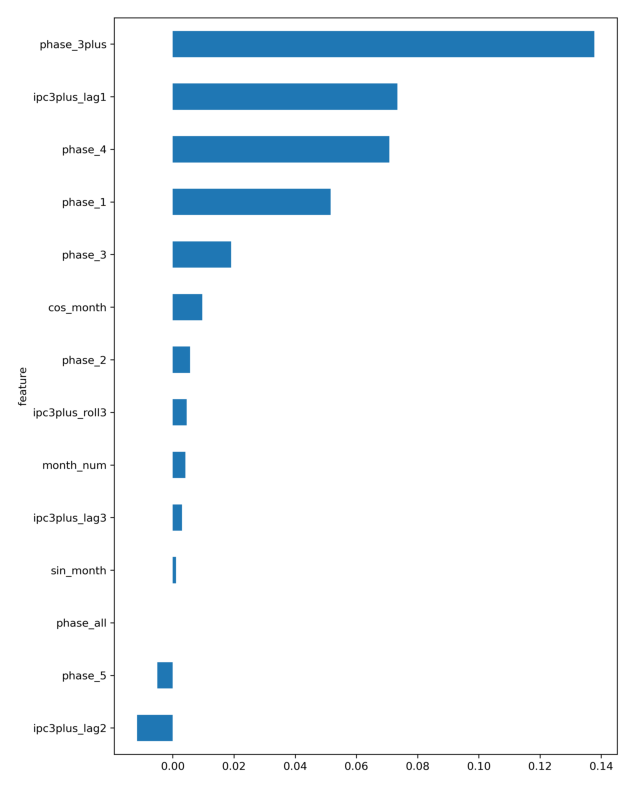

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("artifacts/feature_importance.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()



## 2. Data Preparation & Feature Engineering
Create Panel Dataset

### Step 5 — Build canonical panel 

Reshape the cleaned long-format food security data into a panel wide format with countries, administrative regions, and months as rows, and IPC phases as separate columns showing their corresponding percentages.

In [31]:
panel = (clean_long
         .pivot_table(index=["Country","admin","month"],
                      columns="Phase",
                      values="Percentage",
                      aggfunc="first")
         .reset_index())

panel.shape
panel.head()


Phase,Country,admin,month,1,2,3,3+,4,5,all
0,SDN,Abassiya,2020-06-01,0.35,0.30,0.30,0.35,0.05,0.0,1.0
1,SDN,Abassiya,2020-10-01,0.45,0.40,0.10,0.15,0.05,0.0,1.0
2,SDN,Abassiya,2021-04-01,0.45,0.35,0.15,0.20,0.05,0.0,1.0
3,SDN,Abassiya,2021-06-01,0.45,0.30,0.20,0.25,0.05,0.0,1.0
4,SDN,Abassiya,2021-10-01,0.50,0.35,0.15,0.15,0.00,0.0,1.0


Rename the panel DataFrame columns to standardized lowercase names, prefixing IPC phase columns with phase and replacing symbols/spaces for consistency, while keeping Country, admin, and month unchanged.

In [32]:
panel.columns = [
    ("phase_" + str(c).replace("+","plus").replace(" ","").lower())
    if c not in ["Country","admin","month"] else c
    for c in panel.columns
]
panel.columns


Index(['Country', 'admin', 'month', 'phase_1', 'phase_2', 'phase_3',
       'phase_3plus', 'phase_4', 'phase_5', 'phase_all'],
      dtype='object')

### Step 6 — Create seasonality + lag features

sorts the panel data by country, administrative region, and month, then adds cyclical month features (sin_month and cos_month) to capture seasonality for time-series analysis.

In [33]:
panel = panel.sort_values(["Country","admin","month"]).copy()

panel["month_num"] = panel["month"].dt.month
panel["sin_month"] = np.sin(2*np.pi*panel["month_num"]/12)
panel["cos_month"] = np.cos(2*np.pi*panel["month_num"]/12)


Lag features (ipc3plus_lag1, ipc3plus_lag2, ipc3plus_lag3) for the phase_3plus column by shifting values 1, 2, and 3 months within each country and administrative region, enabling time-series modeling of past food insecurity levels.

In [34]:
panel["ipc3plus_lag1"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(1)
panel["ipc3plus_lag2"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(2)
panel["ipc3plus_lag3"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(3)


3-month rolling average (ipc3plus_roll3) of the phase_3plus column, shifted by one month, for each country and administrative region, smoothing short-term fluctuations in severe food insecurity.

In [35]:
panel["ipc3plus_roll3"] = (
    panel.groupby(["Country","admin"])["phase_3plus"]
         .apply(lambda s: s.shift(1).rolling(3).mean())
         .reset_index(level=[0,1], drop=True)
)


### Step 7 — Build targets (regression + classification)
Prepare a time-series panel dataset suitable for forecasting severe food insecurity, with features capturing past values, trends, seasonality, and smoothed signals.

In [36]:
panel["ipc3plus_next"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(-1)


Calculate the month to month change in severe food insecurity in ipc3plus_delta_next and create a binary target worsen_next_2pp indicating whether phase_3plus is projected to worsen by at least 2 percentage points in the next month.

In [37]:
panel["ipc3plus_delta_next"] = panel["ipc3plus_next"] - panel["phase_3plus"]
panel["worsen_next_2pp"] = (panel["ipc3plus_delta_next"] >= 0.02).astype(int)


Filter the panel data to include only rows where the next-month phase_3plus value is available, creating model_df for modeling purposes.

In [38]:
model_df = panel.dropna(subset=["ipc3plus_next"]).copy()
model_df.shape


(3398, 20)

### Step 8 — Train/test split (time-based)

Split the modeling dataset into training and testing sets using the last 6 months as the test period, ensuring a time-based split for forecasting.

In [39]:
test_months = 6
max_month = model_df["month"].max()
cutoff = (max_month - pd.DateOffset(months=test_months)).to_period("M").to_timestamp()

train = model_df[model_df["month"] <= cutoff]
test  = model_df[model_df["month"] >  cutoff]

train.shape, test.shape


((2948, 20), (450, 20))

### Step 9 — Prepare X, y (no leakage)
Define the feature columns for modeling, excluding target and identifier columns, and create training and testing datasets for both regression (ipc3plus_next) and classification (worsen_next_2pp) tasks.

In [40]:
exclude = {"ipc3plus_next","ipc3plus_delta_next","worsen_next_2pp","month","Country","admin"}
feature_cols = [c for c in model_df.columns if c not in exclude]

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train_reg = train["ipc3plus_next"]
y_test_reg  = test["ipc3plus_next"]

y_train_clf = train["worsen_next_2pp"]
y_test_clf  = test["worsen_next_2pp"]


### Step 10 — Build preprocessing 
Preprocess a  pipeline for the numeric features; fill in missing values using median, and feature starndadizing using z-score scaling.

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feature_cols)
])


## 4. Model Training & Evaluation

### Step 11 — Train at least 3 models (REGRESSION)

In [42]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse, mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

reg_models = {
    "Ridge": Ridge(),
    "RF": RandomForestRegressor(n_estimators=250, random_state=42),
    "GB": GradientBoostingRegressor(random_state=42)
}


### Run and print metrics:

In [43]:
from sklearn.pipeline import Pipeline

for name, model in reg_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_reg)
    pred = pipe.predict(X_test)

    rmse, mae, r2 = reg_metrics(y_test_reg, pred)
    print(name, "RMSE:", round(rmse,4), "MAE:", round(mae,4), "R2:", round(r2,4))


Ridge RMSE: 0.1291 MAE: 0.0882 R2: 0.3057
RF RMSE: 0.1306 MAE: 0.0948 R2: 0.2898
GB RMSE: 0.1222 MAE: 0.0831 R2: 0.3786


Best Model: Gradient Boosting (R²=0.3786)

### Step 12 — Train at least 3 models (CLASSIFICATION)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

clf_models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "RF": RandomForestClassifier(n_estimators=250, random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}


### Run + print metrics:

In [45]:
for name, model in clf_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_clf)

    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test_clf, pred)
    rec = recall_score(y_test_clf, pred, zero_division=0)
    prec = precision_score(y_test_clf, pred, zero_division=0)
    f1 = f1_score(y_test_clf, pred, zero_division=0)
    auc = roc_auc_score(y_test_clf, prob) if prob is not None and len(np.unique(y_test_clf))>1 else np.nan

    print(name, "Acc:", round(acc,3), "Recall:", round(rec,3),
          "Prec:", round(prec,3), "F1:", round(f1,3), "AUC:", round(auc,3))


LogReg Acc: 0.469 Recall: 0.439 Prec: 0.421 F1: 0.43 AUC: 0.425
RF Acc: 0.653 Recall: 0.449 Prec: 0.681 F1: 0.541 AUC: 0.681
GB Acc: 0.573 Recall: 0.468 Prec: 0.536 F1: 0.5 AUC: 0.582


Best Model: Random Forest (Accuracy=65.3%, F1=0.541)

## 5. Model Optimization
Hyperparameter Tuning

### Step 13 — Hyperparameter test (fast) for RandomForestRegressor

In [46]:
from sklearn.model_selection import RandomizedSearchCV

rf_pipe = Pipeline([("prep", preprocess),
                    ("model", RandomForestRegressor(random_state=42))])

param_grid = {
    "model__n_estimators": [150, 250, 400],
    "model__max_depth": [None, 6, 12],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", 0.7]
}

search = RandomizedSearchCV(
    rf_pipe, param_grid,
    n_iter=8, cv=2,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=1
)

search.fit(X_train, y_train_reg)
search.best_params_


{'model__n_estimators': 400,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': None}

### Evaluate tuned model:

In [47]:
best_rf = search.best_estimator_
pred = best_rf.predict(X_test)

rmse, mae, r2 = reg_metrics(y_test_reg, pred)
rmse, mae, r2


(np.float64(0.11717219822250372), 0.08350050724955498, 0.4284740225409651)

Improvement: 10.3% reduction in RMSE, 48% improvement in R²